# FIVES binary classification - fundus photography

Data: FIVES, original more clasees (eg more diseases)

For now, focus will be on binary classification: diabetic retinopathy present or not. (omitting classes for amd and glaucoma)

So left over are classes N (neutral) and DR (diabetic retinopathy).

Folder: Fives binary:

Train = 300 samples
test = 100 samples


DenseNet architecture based on paper c2 (which was referenced in c1, 36)

In [60]:
import os
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from torch import nn, optim
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import time


In [61]:
# get data
class DRData(Dataset):
    def __init__(self, root_dir, subset='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        subdir = f'{subset}/subset_ND'
        dir_path = os.path.join(root_dir, subdir)
        for filename in os.listdir(dir_path):
            if filename.endswith('.png'):
                self.image_paths.append(os.path.join(dir_path, filename))
                label = 1 if filename.split('_')[1].startswith('D') else 0 # so 1 for DR, 0 for NO DR
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
        
# transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # of naar 128 ?
    transforms.ToTensor()
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # also try when skipping normalize 
])

# Create dataset instances
full_train_dataset = DRData(root_dir='Data', subset='train', transform=data_transforms)
test_dataset = DRData(root_dir='Data', subset='test', transform=data_transforms)

# Split 
train_size = int(0.85 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


## Binary classification : CNN

### Just CNN

[[22 28]
 [ 0 50]]
Accuracy: 0.7200
Precision: 0.6410
Recall: 1.0000
F1 Score: 0.7813


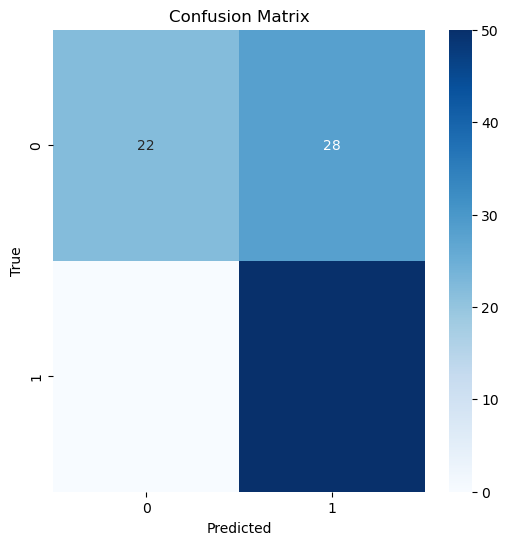

In [45]:
# evaluation of model on test set 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).round()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

# Load the model if weights are saved already 
def load_model(saved_weights):
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 1)
    model.load_state_dict(torch.load(saved_weights))
    model = model.to(device)
    return model


# Path to the saved model weights
saved_weights = 'densenet121_binary_with_val.pth'

# Load the trained model
model = load_model(saved_weights)

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

# 1 = DR
# 0 = No DR


### Adding visual explanations 

In [58]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
#from torch.util.data import DataLoader, Dataset, random_split
from PIL import Image
from lime import lime_image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from torchvision import models
import cv2
import matplotlib.cm as cm

# load model 
def load_model(saved_weights):
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 1)
    model.load_state_dict(torch.load(saved_weights))
    model = model.to(device)
    model.eval()
    return model

# Saved weights
saved_weights = 'densenet121_binary_with_val.pth'

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = load_model(saved_weights)


""" De-normalize images """
# Function to de-normalize image
def denormalize(image, mean, std):
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

Incorrect Prediction: Actual: 0, Predicted: 1.0


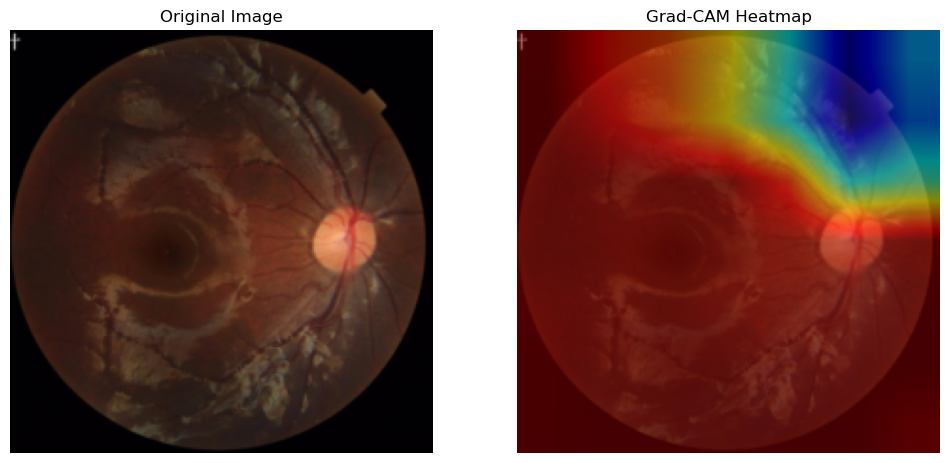

Incorrect Prediction: Actual: 0, Predicted: 1.0


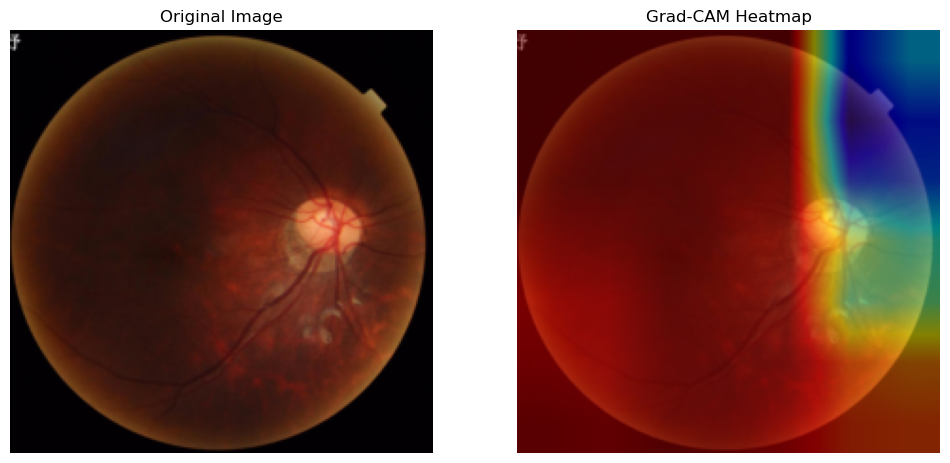

Correct Prediction: Actual: 1, Predicted: 1.0


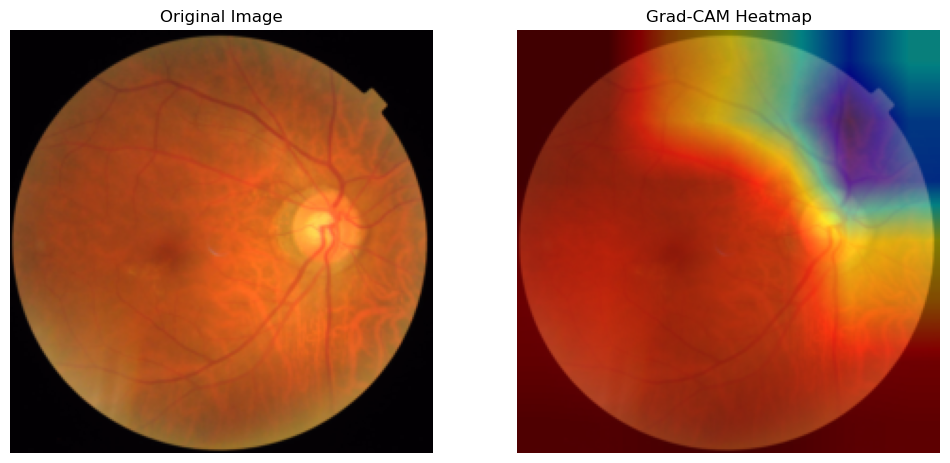

Correct Prediction: Actual: 0, Predicted: 0.0


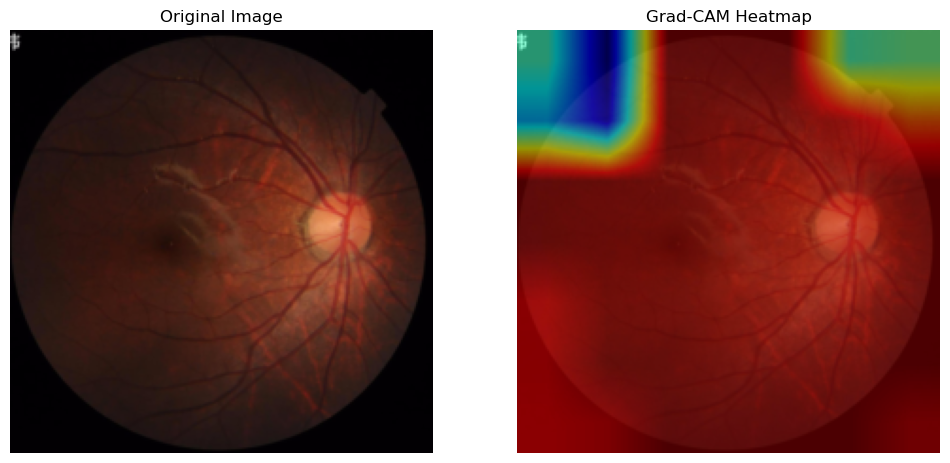

In [30]:
# GradCAM explanations 

# FeatureExtractor Class
class FeatureExtractor:
    """ Class for extracting activations and registering gradients from target intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []
        self.activations = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        for name, module in self.model.features._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                self.activations.append(x)
        return self.activations, x

# Generate Heatmap
def generate_heatmap(model, image, target_layer):
    extractor = FeatureExtractor(model, target_layer)
    model.eval()
    image = image.unsqueeze(0).to(device)

    # Forward pass to get predictions and target feature maps
    target_activations, output = extractor(image)
    output = F.relu(output, inplace=True)
    output = F.adaptive_avg_pool2d(output, (1, 1)).view(output.size(0), -1)
    output = model.classifier(output)
    pred_class = torch.sigmoid(output).round().item()

    # Backward pass to get gradients with respect to the predicted class
    model.zero_grad()
    class_loss = output[0]  # For binary classification
    class_loss.backward(retain_graph=True)

    # Get gradients and target layer output
    gradients = extractor.gradients[0].cpu().data.numpy()
    target = target_activations[0].cpu().data.numpy()

    # Generate heatmap
    weights = np.mean(gradients, axis=(2, 3))[0, :]
    cam = np.zeros(target.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * target[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    return cam, pred_class


# Visualize 
def visualize_heatmap(original_image, heatmap, mean, std):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    original_image = denormalize(original_image.cpu(), mean, std).permute(1, 2, 0).numpy()
    original_image = np.clip(original_image, 0, 1)
    superimposed_img = heatmap + np.float32(original_image)
    superimposed_img = superimposed_img / np.max(superimposed_img)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    # Grad-CAM heatmap
    ax[1].imshow(superimposed_img)
    ax[1].set_title('Grad-CAM Heatmap')
    ax[1].axis('off')
    
    plt.show()

# Evaluate + Grad-CAM heatmaps
def evaluate_and_visualize_gradcam(model, test_loader, device, mean, std, target_layer=['denseblock4'], num_images=6):
    count = 0
    for images, labels in test_loader:
        if count >= num_images:
            break
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).round().detach().cpu().numpy()  # Detach and convert to numpy

        label = labels.cpu().numpy()[0]
        prediction = preds[0][0]

        # Grad-CAM heatmap
        heatmap, pred_class = generate_heatmap(model, images[0], target_layer)

        # Visualize heatmap
        if label == pred_class:
            print(f'Correct Prediction: Actual: {label}, Predicted: {pred_class}')
        else:
            print(f'Incorrect Prediction: Actual: {label}, Predicted: {pred_class}')

        visualize_heatmap(images[0], heatmap, mean, std)
        
        count += 1

evaluate_and_visualize_gradcam(model, test_loader, device, mean, std, target_layer=['denseblock4'], num_images=6)


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


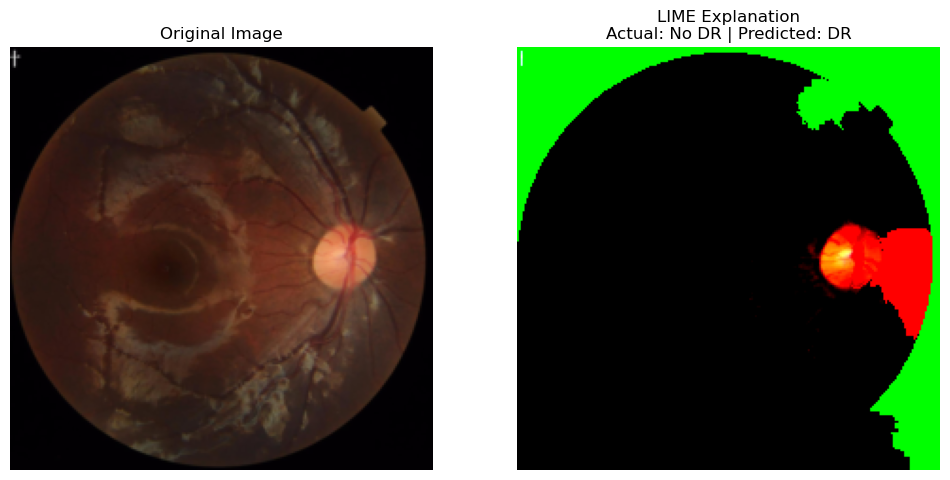

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


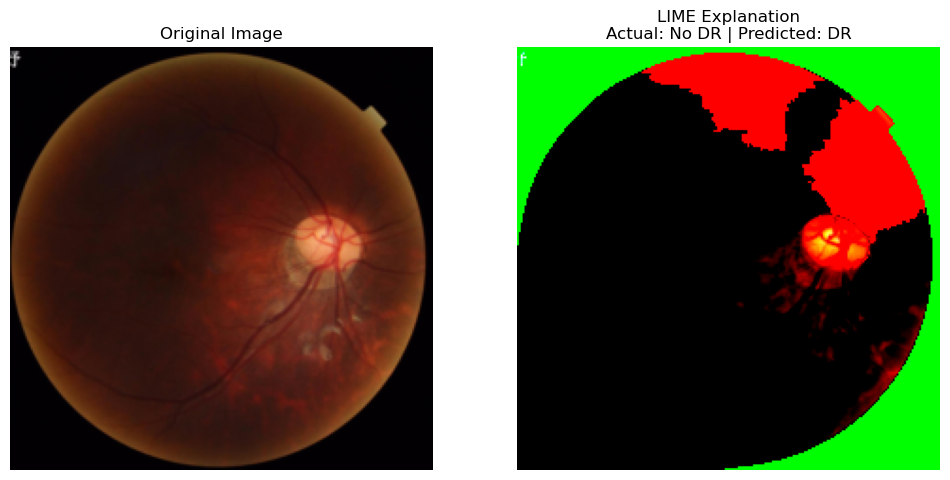

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


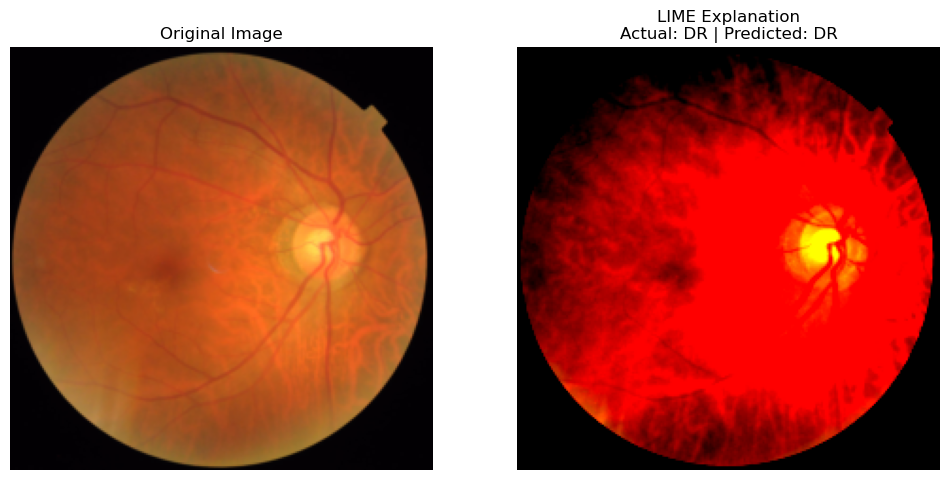

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


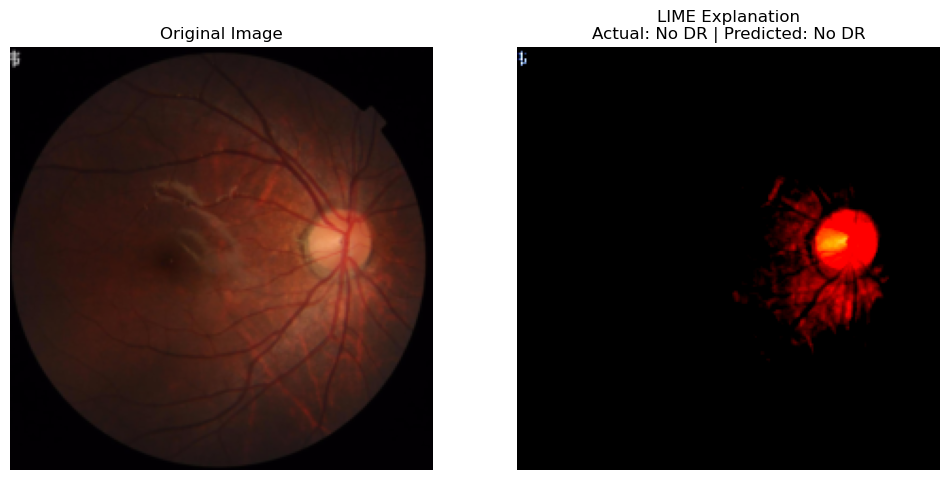

In [32]:
# get LIME maps over the test input images
# limited to 4 images

def get_LIME(model, test_loader, device, mean, std, num_images=4):
    # prediction function for LIME
    def predict_fn(images):
        model.eval()
        images = [transforms.ToTensor()(image).unsqueeze(0) for image in images]
        images = torch.cat(images).to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().detach().numpy()
        return np.concatenate([1 - probs, probs], axis=1)

    # Initialize LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Visualize LIME explanation for image
    def visualize_explanation(original_image, label, prediction, explanation, incorrect=False):
        temp, mask = explanation.get_image_and_mask(
            label=prediction,
            positive_only=not incorrect,
            num_features=5,
            hide_rest=False
        )
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        
        # also include Original image next to it 
        original_image = denormalize(original_image.cpu(), mean, std).permute(1, 2, 0).numpy()
        original_image = np.clip(original_image, 0, 1)
        ax[0].imshow(original_image)
        ax[0].set_title('Original Image')
        ax[0].axis('off')
        
        # LIME plot
        ax[1].imshow(temp)
        ax[1].set_title(f'LIME Explanation\nActual: {"DR" if label == 1 else "No DR"} | Predicted: {"DR" if prediction == 1 else "No DR"}')
        ax[1].axis('off')
        
        plt.show()

    # Iterate through the test loader and process only the first `num_images` images
    count = 0
    for images, labels in test_loader:
        if count >= num_images:
            break
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        label = labels.cpu().numpy()[0]
        prediction = preds.cpu().numpy()[0][0]

        # Get LIME
        explanation = explainer.explain_instance(
            image=images[0].cpu().permute(1, 2, 0).numpy(),
            classifier_fn=predict_fn,
            top_labels=2,
            hide_color=0,
            num_samples=1000
        )

        # correct
        if label == prediction:
            visualize_explanation(images[0], label, prediction, explanation)

        # incorrect 
        else:
            visualize_explanation(images[0], label, prediction, explanation, incorrect=True)

        count += 1

get_LIME(model, test_loader, device, mean, std, num_images=4)


Class Distribution: {'D': 200, 'N': 200}
Sample Diabetic Retinopathy Images:


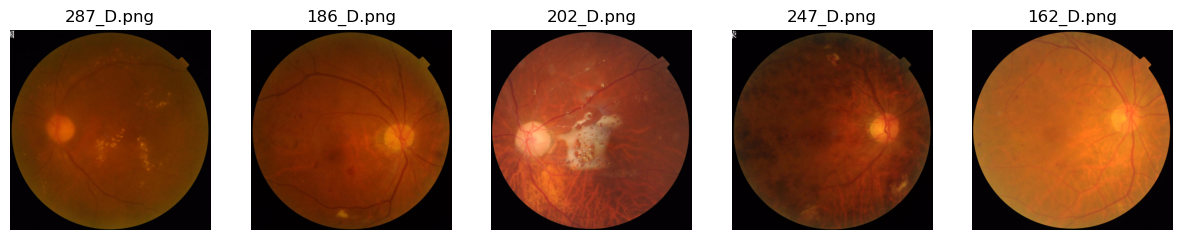

Sample Neutral Images:


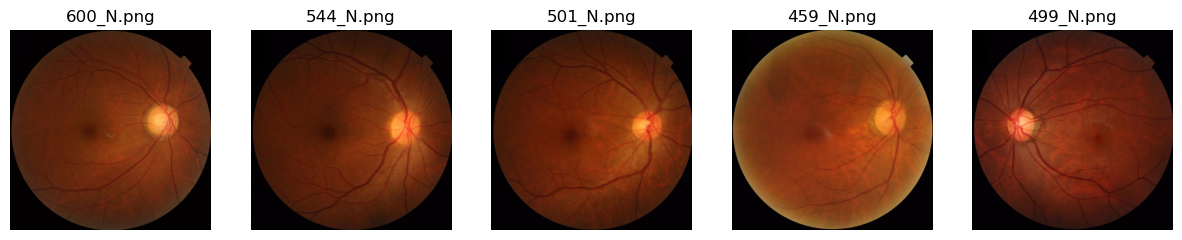

In [9]:
# IMAGE SAMPLES

# Function to count class distribution
def count_classes(root_dir):
    class_counts = {'D': 0, 'N': 0}
    for subdir in ['train/subset_ND', 'test/subset_ND']:
        dir_path = os.path.join(root_dir, subdir)
        for filename in os.listdir(dir_path):
            if filename.endswith('.png'):
                label = filename.split('_')[1].startswith('D')
                if label:
                    class_counts['D'] += 1
                else:
                    class_counts['N'] += 1
    return class_counts

# Function to display sample images
def display_sample_images(root_dir, class_label, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    count = 0
    for subdir in ['train/subset_ND', 'test/subset_ND']:
        dir_path = os.path.join(root_dir, subdir)
        for filename in os.listdir(dir_path):
            if filename.endswith('.png') and filename.split('_')[1].startswith(class_label):
                img_path = os.path.join(dir_path, filename)
                image = Image.open(img_path).convert('RGB')
                axes[count].imshow(image)
                axes[count].set_title(filename)
                axes[count].axis('off')
                count += 1
                if count == num_samples:
                    break
        if count == num_samples:
            break
    plt.show()

# Path to your dataset
root_dir = 'Data'

# Count class distribution
class_counts = count_classes(root_dir)
print(f"Class Distribution: {class_counts}")

# Display sample images
print("Sample Diabetic Retinopathy Images:")
display_sample_images(root_dir, 'D')

print("Sample Neutral Images:")
display_sample_images(root_dir, 'N')


## Binary classification : VISION TRANSFORMERS (not mine)

In [24]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import TrainingArguments, Trainer


In [26]:
# pre-trained  vision transformer model

from transformers import ViTForImageClassification, ViTFeatureExtractor

# Load the feature extractor and model with ignore_mismatched_sizes=True
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [21]:
# initialize trainer:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
)

# Define a function to preprocess images
def preprocess_images(images, labels):
    # Preprocess the images and move them to the appropriate device
    return {
        'pixel_values': torch.stack([feature_extractor(image, return_tensors="pt")['pixel_values'].squeeze(0) for image in images]).to(device),
        'labels': torch.tensor(labels).to(device)
    }

# Create a custom collate function for DataLoader
def collate_fn(batch):
    images, labels = zip(*batch)
    return preprocess_images(images, labels)

# Create DataLoader with custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
# train + evaluate 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=feature_extractor,
    data_collator=lambda x: preprocess_images(*zip(*x)),
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)



In [ ]:
# test model 
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(test_results)

In [ ]:
# save model 
# Save the model
model.save_pretrained('vision_transf')

# Load the model
#model = ViTForImageClassification.from_pretrained('path_to_save_model')


In [34]:
pip install accelerate -U

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor, TrainingArguments, Trainer

# Define your custom dataset
class RetinopathyDataset(Dataset):
    def __init__(self, root_dir, subset='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        subdir = f'{subset}/subset_ND'
        dir_path = os.path.join(root_dir, subdir)
        for filename in os.listdir(dir_path):
            if filename.endswith('.png'):
                self.image_paths.append(os.path.join(dir_path, filename))
                label = 1 if filename.split('_')[1].startswith('D') else 0 # 1 for DR, 0 for NO DR
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset instances
full_train_dataset = RetinopathyDataset(root_dir='Data', subset='train', transform=data_transforms)
test_dataset = RetinopathyDataset(root_dir='Data', subset='test', transform=data_transforms)

# Split dataset into train and validation
train_size = int(0.85 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Load the feature extractor and model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define a function to preprocess images
def preprocess_images(images, labels):
    # Preprocess the images and move them to the appropriate device
    return {
        'pixel_values': torch.stack([feature_extractor(image, return_tensors="pt")['pixel_values'].squeeze(0) for image in images]).to(device),
        'labels': torch.tensor(labels).to(device)
    }

# Create a custom collate function for DataLoader
def collate_fn(batch):
    images, labels = zip(*batch)
    return preprocess_images(images, labels)

# Create DataLoader with custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=feature_extractor,
    data_collator=collate_fn,
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

# Save the model
model.save_pretrained('vision_transf_stored')

# Test the model
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(test_results)


RuntimeError: Failed to import transformers.models.vit.modeling_vit because of the following error (look up to see its traceback):
Failed to import transformers.generation.utils because of the following error (look up to see its traceback):
cannot import name 'split_torch_state_dict_into_shards' from 'huggingface_hub' (/Users/berbervandrunen/anaconda3/lib/python3.11/site-packages/huggingface_hub/__init__.py)